In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

# Find repo root even if notebook runs from /notebooks
ROOT = Path.cwd()
if not (ROOT / "data" / "processed").exists() and (ROOT.parent / "data" / "processed").exists():
    ROOT = ROOT.parent

PROCESSED = ROOT / "data" / "processed"

df = pd.read_csv(PROCESSED / "ethiopia_fi_unified_data_enriched.csv")
event_impacts = pd.read_csv(PROCESSED / "event_impacts_expanded.csv")

obs = df[df["record_type"] == "observation"].copy()
events = df[df["record_type"] == "event"].copy()

print("ROOT:", ROOT)
print("df:", df.shape)
print("event_impacts:", event_impacts.shape)
print("obs:", obs.shape, "events:", events.shape)


ROOT: c:\Users\Hp\Desktop\ethiopia-fi-forecast
df: (46, 34)
event_impacts: (13, 43)
obs: (32, 34) events: (11, 34)


In [4]:
access_code = "ACC_OWNERSHIP"     # Access target
usage_code  = "USG_ACTIVE_RATE"   # Usage target

access_ts = (
    obs[obs["indicator_code"] == access_code]
    .copy()
    .sort_values("observation_date")[["observation_date", "value_numeric"]]
    .rename(columns={"value_numeric": "access"})
)

usage_ts = (
    obs[obs["indicator_code"] == usage_code]
    .copy()
    .sort_values("observation_date")[["observation_date", "value_numeric"]]
    .rename(columns={"value_numeric": "usage"})
)

display(access_ts)
display(usage_ts)


,observation_date,access
0,2014-12-31 00:00:00,22.0
1,2017-12-31 00:00:00,35.0
2,2021-12-31 00:00:00,46.0
3,2021-12-31 00:00:00,56.0
4,2021-12-31 00:00:00,36.0
5,2024-11-29 00:00:00,49.0


,observation_date,usage
24,2024-12-31 00:00:00,66.0


In [5]:
from sklearn.linear_model import LinearRegression

def trend_forecast(ts, value_col, start_year=2025, end_year=2027):
    ts = ts.copy()
    ts["year"] = pd.to_datetime(ts["observation_date"]).dt.year

    X = ts[["year"]]
    y = ts[value_col]

    model = LinearRegression().fit(X, y)

    future = pd.DataFrame({"year": list(range(start_year, end_year + 1))})
    future["baseline"] = model.predict(future[["year"]])
    return future

access_baseline = trend_forecast(access_ts, "access")
usage_baseline  = trend_forecast(usage_ts, "usage")

print("Access baseline:")
display(access_baseline)

print("Usage baseline:")
display(usage_baseline)


Access baseline:


,year,baseline
0,2025,55.684211
1,2026,58.500000
2,2027,61.315789


Usage baseline:


,year,baseline
0,2025,66.0
1,2026,66.0
2,2027,66.0


In [6]:
event_impacts["event_year"] = pd.to_datetime(event_impacts["observation_date"], errors="coerce").dt.year

event_score = (
    event_impacts.groupby("event_year")["impact_weight"]
    .sum()
    .reset_index()
    .rename(columns={"impact_weight": "event_score"})
)

print("Yearly event_score (sum of impact_weight):")
display(event_score)


Yearly event_score (sum of impact_weight):


,event_year,event_score
0,2021.0,1.5
1,2023.0,1.0
2,2024.0,1.5
3,2025.0,1.0


In [7]:
def apply_event_uplift(baseline_df, event_score_df, scale=1.0):
    out = baseline_df.merge(event_score_df, left_on="year", right_on="event_year", how="left")
    out["event_score"] = out["event_score"].fillna(0)
    out["forecast"] = out["baseline"] + scale * out["event_score"]
    return out[["year", "forecast"]]

# Access scenarios
access_pess = apply_event_uplift(access_baseline, event_score, scale=0.5)
access_base = apply_event_uplift(access_baseline, event_score, scale=1.0)
access_opt  = apply_event_uplift(access_baseline, event_score, scale=1.5)

# Usage scenarios
usage_pess = apply_event_uplift(usage_baseline, event_score, scale=0.5)
usage_base = apply_event_uplift(usage_baseline, event_score, scale=1.0)
usage_opt  = apply_event_uplift(usage_baseline, event_score, scale=1.5)

print("Access scenarios:")
display(pd.DataFrame({
    "year": access_base["year"],
    "pessimistic": access_pess["forecast"],
    "base": access_base["forecast"],
    "optimistic": access_opt["forecast"],
}))

print("Usage scenarios:")
display(pd.DataFrame({
    "year": usage_base["year"],
    "pessimistic": usage_pess["forecast"],
    "base": usage_base["forecast"],
    "optimistic": usage_opt["forecast"],
}))


Access scenarios:


,year,pessimistic,base,optimistic
0,2025,56.184211,56.684211,57.184211
1,2026,58.500000,58.500000,58.500000
2,2027,61.315789,61.315789,61.315789


Usage scenarios:


,year,pessimistic,base,optimistic
0,2025,66.5,67.0,67.5
1,2026,66.0,66.0,66.0
2,2027,66.0,66.0,66.0


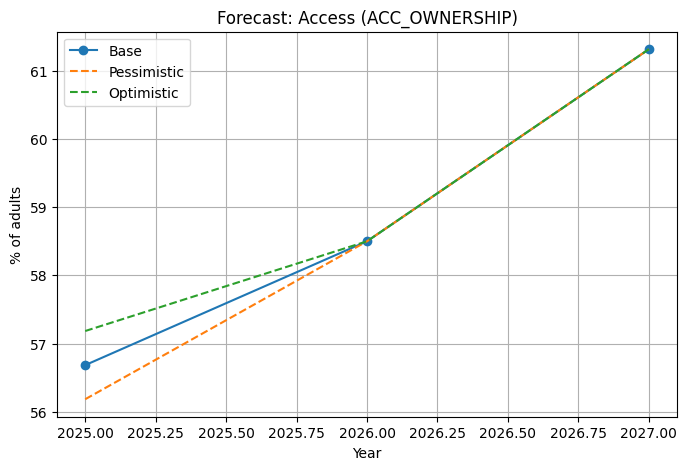

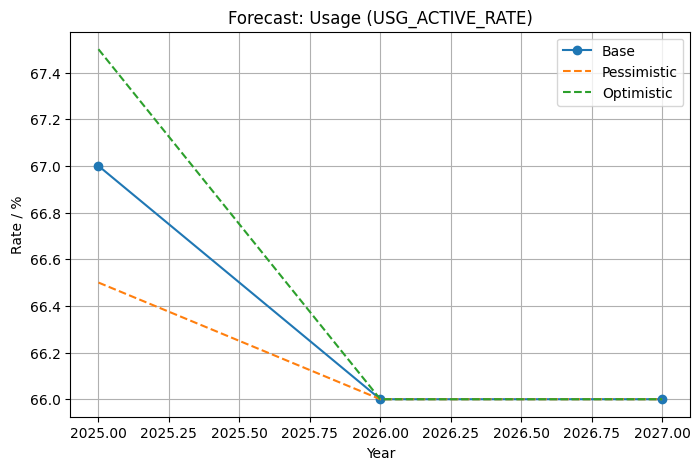

In [8]:
import matplotlib.pyplot as plt

def plot_scenarios(pess, base, opt, title, ylabel):
    plt.figure(figsize=(8,5))
    plt.plot(base["year"], base["forecast"], marker="o", label="Base")
    plt.plot(pess["year"], pess["forecast"], linestyle="--", label="Pessimistic")
    plt.plot(opt["year"], opt["forecast"], linestyle="--", label="Optimistic")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_scenarios(access_pess, access_base, access_opt,
               "Forecast: Access (ACC_OWNERSHIP)", "% of adults")

plot_scenarios(usage_pess, usage_base, usage_opt,
               "Forecast: Usage (USG_ACTIVE_RATE)", "Rate / %")


In [9]:
forecast_out = pd.DataFrame({
    "year": access_base["year"],
    "access_pessimistic": access_pess["forecast"],
    "access_base": access_base["forecast"],
    "access_optimistic": access_opt["forecast"],
    "usage_pessimistic": usage_pess["forecast"],
    "usage_base": usage_base["forecast"],
    "usage_optimistic": usage_opt["forecast"],
})

forecast_out.to_csv(PROCESSED / "forecast_2025_2027.csv", index=False)
print("Saved:", PROCESSED / "forecast_2025_2027.csv")
display(forecast_out)


Saved: c:\Users\Hp\Desktop\ethiopia-fi-forecast\data\processed\forecast_2025_2027.csv


,year,access_pessimistic,access_base,access_optimistic,usage_pessimistic,usage_base,usage_optimistic
0,2025,56.184211,56.684211,57.184211,66.5,67.0,67.5
1,2026,58.500000,58.500000,58.500000,66.0,66.0,66.0
2,2027,61.315789,61.315789,61.315789,66.0,66.0,66.0
